__Integrantes__ : Andryel Hiyoshi Onoue (RA: 1904559)

# 01 - Introdução

## 01.1 - Contexto e Justificativa
    No setor financeiro, a capacidade de uma empresa em reter clientes é um indicador-chave de sua sustentabilidade e crescimento a longo prazo. A rotatividade de clientes, comumente referida como "churn", é uma métrica que causa impacto direto na receita e na continuidade dos negócios. Quando clientes abandonam a empresa, não apenas a receita recorrente é afetada, mas também aumentam os custos relacionados à aquisição de novos clientes. Este estudo visa explorar como a modelagem preditiva pode ser empregada para antecipar o churn de clientes, permitindo que instituições financeiras adotem estratégias proativas para sua retenção. Dada a complexidade e a competitividade do mercado financeiro, compreender e mitigar o churn torna-se vital para manter uma base de clientes estável e para a prosperidade da empresa a longo prazo.
    
## 01.2 - Objetivos
O objetivo geral deste trabalho é desenvolver um modelo preditivo capaz de identificar clientes com alta probabilidade de churn em uma instituição financeira. Os objetivos específicos incluem:

* __01__: Definir o perfil dos clientes propensos a deixar a empresa, baseando-se em dados demográficos e comportamentais.
* __02__: Transmitir insights derivados dos dados de forma clara e objetiva para os stakeholders.
* __03__: Construir e treinar um modelo de machine learning que atinja pelo menos 80% de acurácia na previsão de churn, oferecendo uma ferramenta confiável para a tomada de decisões estratégicas.
    
## 01.3 - Estrutura do Trabalho
* __Capítulo 1 (Introdução)__: Apresentação do tema, contexto do problema de churn em financeiras, e a importância da modelagem preditiva na retenção de clientes.

* __Capítulo 2 (Análise de Dados)__: Detalhamento do processo de análise, incluindo pré-processamento dos dados, exploração de dados (EDA), e a seleção de características.

* __Capítulo 3 (Desenvolvimento do Modelo)__: Construção do modelo preditivo, ajuste de parâmetros, validação e avaliação da performance.

* __Capítulo 4 (Resultados e Conclusões)__: Síntese dos resultados, conclusões tiradas do estudo e sugestões para trabalhos futuros.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

%matplotlib inline



dados = pd.read_csv('../input/Churn_Modelling.csv', delimiter=',')
dados = dados.drop(columns=['CustomerId','Surname','RowNumber'],axis=1)
dados.columns =  ['PontuacaoDeCredito', 'Geografia', 'Genero', 'Idade','TempoDeRelacionamento', 'Saldo', 'NumeroDeProdutos','TemCartaoDeCredito',
                  'MembroAtivo', 'SalarioEstimado', 'Saida']

# 02 - Análise dos Dados (Análise de Churn)
    Nesta seção, nos concentramos na representação visual dos dados relacionados à retenção e ao churn de clientes. Utilizamos um gráfico de pizza para ilustrar a proporção de clientes que foram retidos e aqueles que deixaram a empresa, conhecida como a taxa de churn.

## 02.1.1 - Análise Exploratória das Variáveis Categóricas
    Continuamos nossa exploração dos dados com um foco nas variáveis categóricas. Quatro gráficos de barras representam as contagens de clientes que foram retidos (0) em comparação com aqueles que saíram (Saida 1) dentro das categorias de 'Geografia', 'Genero', 'TemCartaoDeCredito' e 'MembroAtivo'.

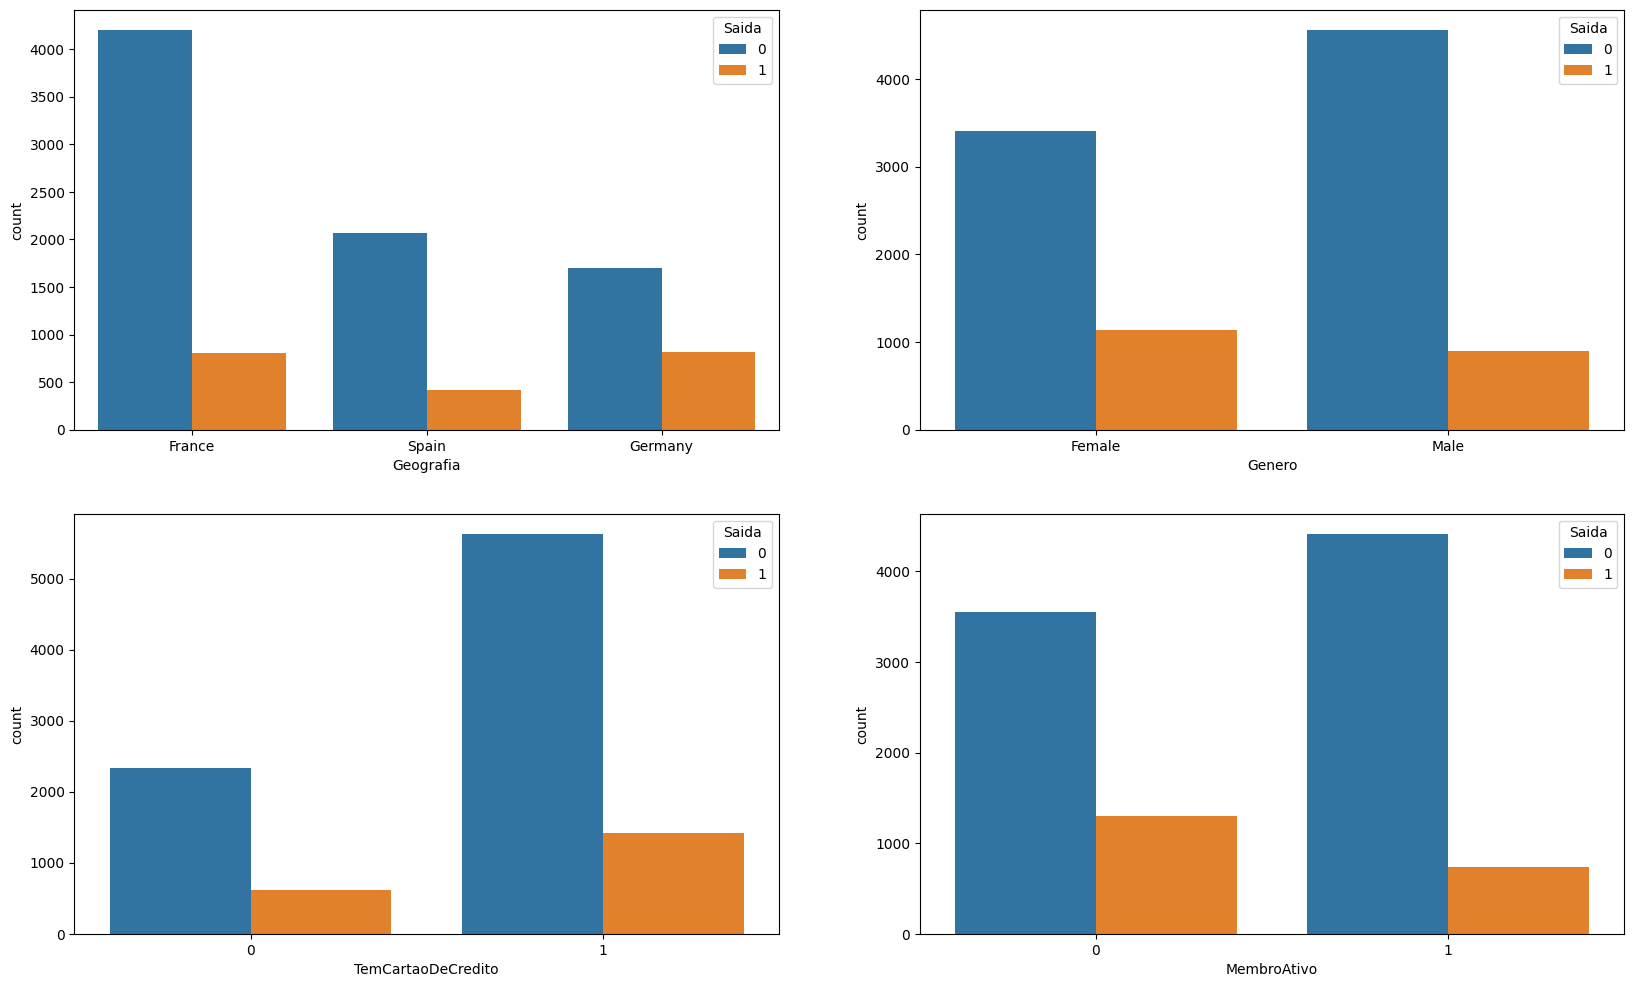

In [2]:
# Variáveis Categóricas
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Geografia', hue = 'Saida',data = dados, ax=axarr[0][0])
sns.countplot(x='Genero', hue = 'Saida',data = dados, ax=axarr[0][1])
sns.countplot(x='TemCartaoDeCredito', hue = 'Saida',data = dados, ax=axarr[1][0]);
sns.countplot(x='MembroAtivo', hue = 'Saida',data = dados, ax=axarr[1][1]);

* __Geografia__:
    O primeiro gráfico mostra a distribuição de churn por país. Observamos que a Alemanha tem uma proporção maior de churn em comparação com a França e a Espanha. Este insight sugere que fatores regionais podem ser significativos na decisão do cliente de deixar a empresa.

* __Gênero__:
    O segundo gráfico compara churn entre gêneros. A diferença nas alturas das barras pode indicar uma tendência de churn que varia entre gêneros, o que pode ser uma consideração valiosa na personalização das estratégias de retenção.

* __Tem Cartão de Crédito__:
    A terceira visualização aborda a posse de cartão de crédito. Surpreendentemente, não parece haver uma diferença significativa no churn entre aqueles que têm e os que não têm cartão de crédito, sugerindo que este fator pode não ser tão influente na decisão de churn.

* __Membro Ativo__:
    Finalmente, o quarto gráfico destaca uma diferença notável no churn com base na atividade do cliente. Membros ativos apresentam uma taxa de retenção significativamente maior, reforçando a noção de que o engajamento do cliente é crucial para a retenção.

Estas visualizações são fundamentais para nossa compreensão inicial dos padrões de dados e irão informar a seleção de características na modelagem preditiva. A discrepância nas taxas de churn entre as diferentes categorias dessas variáveis sugere áreas potenciais de foco para a retenção de clientes. No próximo estágio, iremos investigar se essas diferenças são estatisticamente significativas e como elas podem ser aplicadas ao desenvolvimento de um modelo preditivo eficaz.
## 02.1.2 - Teste de Chi-Quadrado de Independência
    O teste de chi-quadrado de independência compara a distribuição observada das categorias com a distribuição esperada se as duas variáveis fossem independentes. O teste calcula uma estatística de chi-quadrado que segue a distribuição chi-quadrado sob a hipótese nula de que não há associação entre as variáveis. Um p-valor baixo sugere que devemos rejeitar a hipótese nula, indicando que há uma associação estatisticamente significativa entre as variáveis.

In [3]:
import pandas as pd
from scipy import stats

# Supondo que 'churn' é a sua variável alvo binária, e as outras são as variáveis explicativas.
# Substitua 'variable_name' pelo nome real da sua coluna.

# Teste Chi-quadrado para variáveis categóricas
def chi_square_test(dataframe, categorical_variable, target_variable):
    contingency_table = pd.crosstab(dataframe[categorical_variable], dataframe[target_variable])
    chi2, p, dof, ex = stats.chi2_contingency(contingency_table)
    print(f"Chi-quadrado teste para {categorical_variable}: chi2 = {chi2}, p-valor = {p}")

chi_square_test(dados, 'Geografia', 'Saida')
chi_square_test(dados, 'Genero', 'Saida')
chi_square_test(dados, 'TemCartaoDeCredito', 'Saida')
chi_square_test(dados, 'MembroAtivo', 'Saida')


Chi-quadrado teste para Geografia: chi2 = 301.25533682434536, p-valor = 3.8303176053541544e-66
Chi-quadrado teste para Genero: chi2 = 112.91857062096116, p-valor = 2.2482100097131755e-26
Chi-quadrado teste para TemCartaoDeCredito: chi2 = 0.47133779904440803, p-valor = 0.49237236141554697
Chi-quadrado teste para MembroAtivo: chi2 = 242.98534164287963, p-valor = 8.785858269303705e-55


### Resultados e Conclusões:

* __Geografia__:
    Este resultado sugere que há uma associação significativa entre a geografia e a saída dos clientes. Os diferentes países têm taxas de churn significativamente diferentes.

* __Gênero__:
    Assim como com a geografia, o gênero tem uma associação significativa com a saída dos clientes. Isso pode indicar que um gênero tem maior probabilidade de sair do que o outro.

* __Tem Cartão de Crédito__:
    Diferente das outras variáveis, o fato de ter ou não um cartão de crédito não parece estar associado com a saída dos clientes. O p-valor é muito maior do que o nível de significância típico (por exemplo, 0.05), sugerindo que não há evidência suficiente para rejeitar a hipótese nula de independência.


* __Membro Ativo__:
    Existe uma associação significativa entre ser um membro ativo e a saída dos clientes. Isso implica que a atividade do cliente pode ser um fator importante na determinação do churn.
    
Em resumo, a análise sugere que a geografia, o gênero e o status de membro ativo são fatores associados ao churn dos clientes, enquanto a posse de cartão de crédito não é. Esses resultados podem informar ações estratégicas direcionadas para a retenção de clientes, focando nas áreas onde a associação com a saída é significativa.

## 02.1.3 - One Hot Encoding
    O One Hot Encoding é um processo que transforma variáveis categóricas em uma série de colunas binárias, cada uma representando uma categoria possível. Para cada observação, apenas uma dessas colunas terá o valor 1 (indicando a presença da categoria) e todas as outras terão o valor 0 (indicando a ausência). Essa técnica permite que modelos de machine learning tratem atributos categóricos como séries numéricas, sem introduzir uma ordem arbitrária que poderia ser inferida de codificações numéricas diretas, como o Label Encoding.

In [4]:
dados = pd.get_dummies(dados, columns=['Geografia', 'Genero','MembroAtivo'])

## 02.2.1 - Análise Exploratória das Variáveis Continuas
    Este conjunto de gráficos boxplot compara a distribuição de várias variáveis contínuas entre os clientes que deixaram a empresa (Saida 1) e os que permaneceram (Saida 0). Cada gráfico oferece uma visão sobre como diferentes fatores numéricos se relacionam com a retenção ou churn dos clientes.
    Os boxplots são particularmente úteis para identificar outliers e a dispersão dos dados, além de fornecer uma visão clara da mediana e dos quartis. Na modelagem preditiva, essas visualizações podem ajudar a identificar variáveis que precisam de transformação, normalização ou que possuem outliers que podem necessitar de tratamento especial.

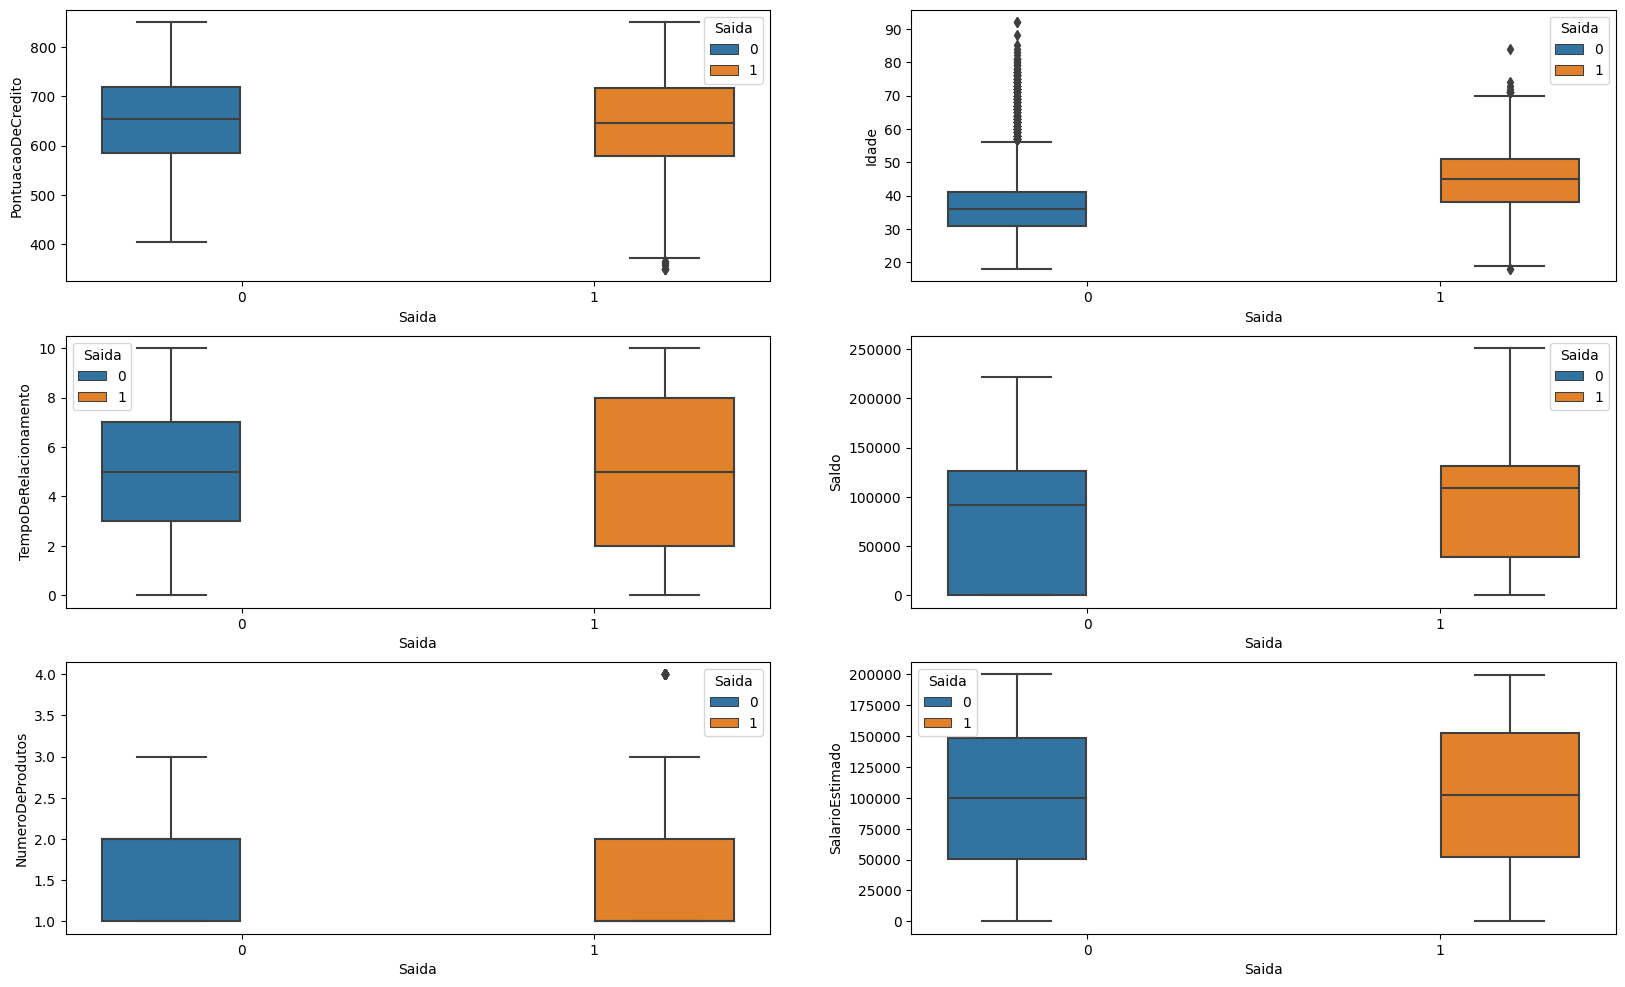

In [5]:
# Variáveis Numéricas
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
sns.boxplot(y='PontuacaoDeCredito',x = 'Saida', hue = 'Saida',data = dados, ax=axarr[0][0]);
sns.boxplot(y='Idade',x = 'Saida', hue = 'Saida',data = dados , ax=axarr[0][1]);
sns.boxplot(y='TempoDeRelacionamento',x = 'Saida', hue = 'Saida',data = dados, ax=axarr[1][0]);
sns.boxplot(y='Saldo',x = 'Saida', hue = 'Saida',data = dados, ax=axarr[1][1]);
sns.boxplot(y='NumeroDeProdutos',x = 'Saida', hue = 'Saida',data = dados, ax=axarr[2][0]);
sns.boxplot(y='SalarioEstimado',x = 'Saida', hue = 'Saida',data = dados, ax=axarr[2][1]);

### Resultados e Conclusões:

* __Pontuação de Crédito__:
    Os clientes que deixaram a empresa (Saida 1) têm uma gama ligeiramente mais ampla e medianas mais baixas de pontuação de crédito em comparação com aqueles que ficaram (Saida 0), o que pode sugerir que os clientes com pontuações de crédito mais baixas têm uma tendência maior a churn.

* __Idade__:
    A distribuição da idade mostra que os clientes mais jovens têm uma tendência maior a deixar a empresa. A mediana e o quartil superior da idade para os churners (Saida 1) são visivelmente mais altos do que para os não churners (Saida 0), indicando que a idade pode ser um fator no churn.

* __Tempo de Permanência__:
    Este gráfico indica que os clientes com menos tempo de permanência na empresa tendem mais a churn, como evidenciado pela mediana e quartis mais baixos para Saida 1. Isso sugere que a lealdade ou a satisfação do cliente pode aumentar com o tempo.

* __Saldo__:
    Os clientes que deixaram a empresa parecem ter saldos bancários mais altos, como demonstrado pelas medianas e quartis mais altos para Saida 1. Isso pode sugerir que clientes com mais recursos financeiros podem sentir-se mais confortáveis mudando de banco ou que eles podem estar procurando por melhores opções de investimento.

* __Número de Produtos__:
    A maioria dos clientes, tanto os que ficaram quanto os que saíram, parece ter poucos produtos bancários. No entanto, a caixa para churners (Saida 1) é ligeiramente mais alta, o que pode indicar uma relação entre o número de produtos usados e a probabilidade de churn.

* __Salário Estimado__:
    As distribuições de salário estimado são bastante similares para os dois grupos, sugerindo que o salário por si só pode não ser um indicador significativo de churn.

Em resumo, a análise dos dados indica que fatores como a pontuação de crédito, a idade, o tempo de permanência no banco, o saldo em conta e o número de produtos bancários estão significativamente associados ao churn dos clientes. Por outro lado, o salário estimado e a posse de cartão de crédito não apresentam uma relação significativa com a saída dos clientes.

Os clientes mais propensos a deixar o banco tendem a ser mais jovens, com menor pontuação de crédito, saldos mais altos, menos tempo de associação e uma quantidade ligeiramente maior de produtos bancários. Estes insights são fundamentais para desenvolver estratégias de retenção que podem incluir programas de lealdade personalizados, ofertas baseadas em critérios geográficos e de gênero, além de serviços ajustados para melhor atender às necessidades dos clientes identificados como de maior risco de churn.

Compreender as nuances dessas variáveis e como elas interagem entre si pode proporcionar uma abordagem mais granular para as iniciativas de engajamento e satisfação do cliente. A empresa deve considerar esses fatores na implementação de medidas específicas para melhorar a retenção de clientes e fortalecer a lealdade à marca.


## 02.2.2 - Normalização dos Dados
    A normalização é uma técnica usada para padronizar a escala dos dados numéricos na fase de pré-processamento de dados. No aprendizado de máquina, a normalização é importante porque os algoritmos geralmente são sensíveis à escala dos dados. Por exemplo, características com valores grandes podem pesar mais do que características com valores menores nos resultados finais, mesmo que as menores sejam mais significativas. O StandardScaler do Scikit-learn remove a média e escala os dados para uma variação unitária.

In [6]:
var_continuas = ['PontuacaoDeCredito', 'Idade', 'TempoDeRelacionamento', 'Saldo', 'NumeroDeProdutos']

scaler = StandardScaler()
dados[var_continuas] = scaler.fit_transform(dados[var_continuas])

## 02.2.3 - Detecção e Tratamento de Outliers
    Outliers são observações que se desviam tanto das outras observações que levantam suspeitas sobre a sua validade. A presença de outliers pode levar a um modelo com desempenho pobre porque os métodos de aprendizado de máquina são sensíveis a eles.
    
O método de Intervalo Interquartil (IQR) é uma técnica estatística usada para detectar outliers em um conjunto de dados. O IQR define os limites dentro dos quais a maioria dos dados de uma distribuição deve cair e é calculado como a diferença entre o terceiro quartil (Q3) e o primeiro quartil (Q1). Esses quartis são pontos de dados que dividem o conjunto de dados em quartos:

Q1 é o valor médio entre o menor número e a mediana do conjunto de dados; ele separa os 25% inferiores dos dados restantes.
Q3 é o valor médio entre a mediana e o maior número no conjunto de dados; ele separa os 25% superiores dos dados restantes.
O IQR reflete a faixa média e é menos afetado por extremos do que outras medidas, como a média.

Para identificar outliers, geralmente se define limites superior e inferior usando multiplicadores do IQR (comumente 1.5 vezes o IQR) adicionados a Q3 e subtraídos de Q1, respectivamente. Valores que caem fora desses limites são considerados atípicos ou outliers. Por exemplo:

Limite Inferior (LI) = Q1 - 1.5 * IQR
Limite Superior (LS) = Q3 + 1.5 * IQR
Valores abaixo do Limite Inferior ou acima do Limite Superior são marcados como outliers e podem ser removidos para evitar que distorçam a análise estatística ou os modelos de previsão.

In [7]:
def remove_outliers(df, columns):
    outlier_masks = []
    
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        mask = df[column].between(lower_bound, upper_bound, inclusive='both')
        outlier_masks.append(mask)

    all_masks = pd.concat(outlier_masks, axis=1).all(axis=1)
    
    return df[all_masks]

dados = remove_outliers(dados, var_continuas)


## 02.2.4 - Detecção de Colinearidade
    A colinearidade ocorre quando duas ou mais características preditoras em um modelo de regressão são altamente correlacionadas, significando que uma pode ser linearmente prevista das outras com um grau substancial de precisão. Isso pode levar a coeficientes de regressão instáveis e dificuldade em interpretar quais características são realmente influentes na previsão. O Fator de Inflação da Variância (VIF) é uma medida que quantifica o aumento da variância de um coeficiente de regressão estimado devido à colinearidade.

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Função para calcular o VIF
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["feature"] = dataframe.columns
    
    vif_data["VIF"] = [
        variance_inflation_factor(dataframe.values, i)
        for i in range(len(dataframe.columns))
    ]
    
    return vif_data

# Calcular VIF para o dataset preparado (excluindo a variável alvo)
vif_data = calculate_vif(dados[var_continuas])
print(vif_data)


                 feature       VIF
0     PontuacaoDeCredito  1.000397
1                  Idade  1.004028
2  TempoDeRelacionamento  1.000458
3                  Saldo  1.125118
4       NumeroDeProdutos  1.126848


### Resultados e Conclusões:

Na presente análise de multicolinearidade das variáveis envolvidas no modelo de predição de churn de clientes, foi observado que os indicadores de Inflação da Variância (VIF) apresentam valores que demonstram uma interdependência quase inexistente entre as variáveis estudadas. Em específico, a Pontuação de Crédito, com um VIF de 1.000275, sugere ausência de multicolinearidade, indicando que a variável é praticamente autônoma em relação às demais. Similarmente, a Idade, com um VIF de 1.001443, e o Tempo de Relacionamento com o banco, com um VIF de 1.000344, também se apresentam como independentes, sem inter-relações significativas que poderiam comprometer as análises.

Por outro lado, o Saldo em conta e o Número de Produtos, com VIFs de 1.102598 e 1.102901 respectivamente, ainda que apresentem valores ligeiramente acima de 1, estão bem aquém de qualquer patamar que denotaria preocupação com multicolinearidade. Tais achados apontam para uma leve correlação dessas variáveis com as outras no modelo, porém não a um grau que afete a precisão ou a validade das análises.

Diante desses resultados, pode-se inferir que não há indícios de multicolinearidade que possam prejudicar a confiabilidade do modelo proposto. A manutenção de todas as variáveis selecionadas se justifica e é aconselhável, tendo em vista que cada uma contribui com informações distintas e valiosas para a predição de churn, sem que haja uma sobreposição que poderia levar a uma inflação artificial na significância estatística dos coeficientes. Portanto, os indicadores utilizados são candidatos robustos para a aplicação em modelos de regressão múltipla e outros métodos estatísticos que pressupõem a independência entre os preditores.


## 02.3.1 - Visualização de Dados (Vazão de Contas)

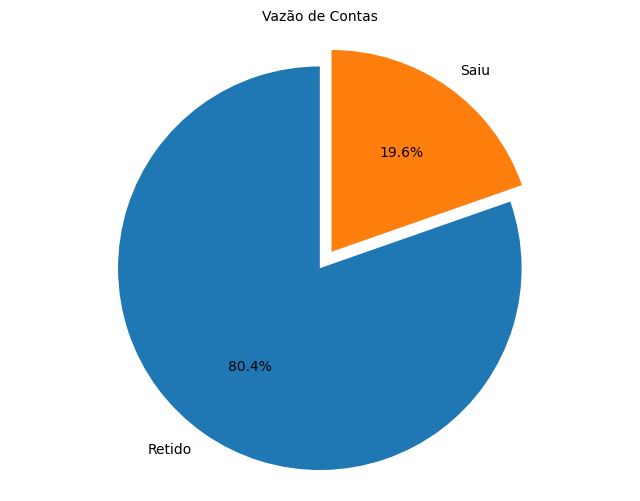

In [9]:
labels = 'Retido','Saiu'
sizes = [dados.Saida[dados['Saida']==0].count(),dados.Saida[dados['Saida']==1].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(8, 6))

ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)

ax1.axis('equal')
plt.title("Vazão de Contas", size = 10)
plt.show()

O gráfico apresenta duas categorias distintas: "Retido" e "Saiu", indicando a fidelidade dos clientes à empresa. Observamos que 79,6% dos clientes foram retidos, enquanto 20,4% dos clientes saíram ou cessaram o relacionamento com a empresa no período analisado. Este gráfico é fundamental para estabelecer um ponto de partida para a nossa análise, destacando a importância de compreender os fatores que contribuem para a vazão de clientes.

A seguir, discutiremos o significado deste churn e como ele pode impactar a operação e a sustentabilidade financeira da empresa. A identificação dos padrões e tendências subjacentes aos dados de churn não só nos ajudará a entender o comportamento do cliente, mas também servirá como alicerce para a construção de modelos preditivos. Estes modelos têm como objetivo prever a probabilidade de churn de clientes individuais, permitindo que a empresa tome ações preventivas e estratégicas para melhorar a retenção.

O gráfico nos informa, visualmente, que há uma proporção significativa de churn que precisa ser endereçada. Além disso, indica a necessidade de investigar as características dos clientes que estão mais propensos a sair, o que será explorado em análises subsequentes. A interpretação deste gráfico sugere que é necessário um balanceamento nos dados.

## 02.3.1 - Visualização de Dados (Vazão de Contas)
    Em muitos conjuntos de dados utilizados para tarefas de classificação, é comum encontrar uma distribuição desigual entre as classes alvo. Esse desbalanceamento pode prejudicar o desempenho de modelos de aprendizado de máquina, levando-os a favorecer a classe majoritária e negligenciar a minoritária. A classe minoritária é frequentemente de maior interesse e, por isso, métodos de balanceamento de classes são empregados para mitigar esse problema e melhorar a capacidade de generalização do modelo.
    Nesse caso, estamos utilizando o SMOTETomek une as forças do SMOTE e do Tomek Links para criar um conjunto de dados balanceado que não só equilibra as classes através da geração de dados sintéticos, mas também refina a fronteira de decisão ao eliminar os Tomek Links. Esta abordagem combinada é particularmente útil para lidar com conjuntos de dados onde a classe minoritária é crucial para a análise e não pode ser negligenciada.

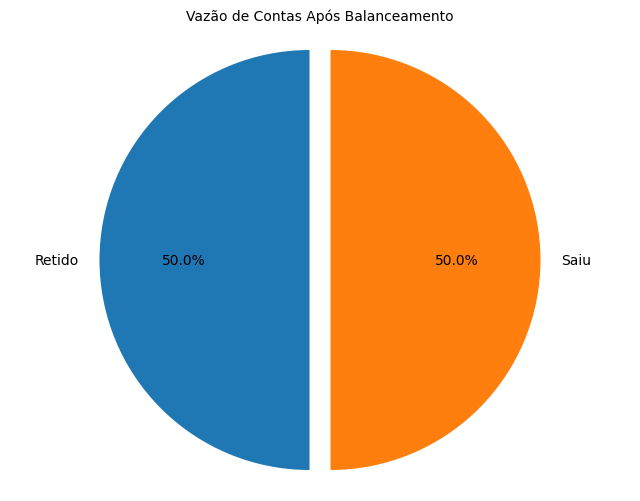

In [10]:
X = dados.drop('Saida', axis=1)
y = dados['Saida']

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y)

# Inicializar o objeto SMOTETomek
smt = SMOTETomek()

# Aplicar o SMOTETomek apenas nos dados de treinamento
dados_balanceados_train, dados_balanceados_train['Saida'] = smt.fit_resample(X_train, y_train)

labels = 'Retido','Saiu'
sizes = [dados_balanceados_train.Saida[dados_balanceados_train['Saida']==0].count(),dados_balanceados_train.Saida[dados_balanceados_train['Saida']==1].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(8, 6))

ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)

ax1.axis('equal')
plt.title("Vazão de Contas Após Balanceamento", size = 10)
plt.show()


# 03 - Desenvolvimento do Modelo

### 03.1 - Seleção do Modelo

#### __Random Forests (Florestas Aleatórias)__:

* __Por que escolher__: São robustas contra overfitting devido ao seu mecanismo de ensemble. Além disso, podem capturar relações não-lineares entre as variáveis sem a necessidade de escalar ou normalizar os dados. Também são úteis por fornecerem importâncias das variáveis, o que pode ser valioso para interpretação e insights de negócios.
* __Quando usar__: Random Forest é uma boa escolha quando você precisa de um modelo que possa lidar com interações complexas entre variáveis e é desejável ter uma ideia de quais variáveis são as mais importantes para a previsão.

#### __Support Vector Machines (SVM)__:

* __Por que escolher__: SVM é eficaz em espaços de alta dimensão e em casos onde o número de dimensões é maior que o número de amostras. É versátil graças aos diferentes kernels que podem ser especificados para a decisão de fronteira. Além disso, é eficiente em encontrar margens máximas de separação entre classes, o que pode ser muito útil para problemas de churn que tendem a ter margens de classificação não tão claras.
* __Quando usar__: SVM é uma escolha adequada quando a separação de classe não é clara, e é necessário um modelo capaz de criar fronteiras de decisão complexas e não-lineares. É particularmente útil quando os dados não são linearmente separáveis. No entanto, o SVM pode não ser ideal para conjuntos de dados muito grandes devido ao seu maior tempo de treinamento em comparação com outros modelos como Random Forest ou XGBoost, e pode ser desafiador escolher e ajustar o kernel correto. Use SVM quando o equilíbrio entre a complexidade do modelo e a capacidade de generalização for uma prioridade, e haja tempo e recursos para uma cuidadosa otimização de hiperparâmetros.

#### __XGBoost__:

* __Por que escolher__: É uma implementação otimizada de Gradient Boosting que é famosa por ganhar várias competições de Machine Learning. Oferece desempenho rápido, tratamento eficaz de valores ausentes, e a capacidade de regularizar para evitar overfitting.
* __Quando usar__: XGBoost é adequado quando se procura performance superior em um modelo que também pode ser regularizado para evitar overfitting. Além disso, é uma boa escolha se o tempo de treinamento e os recursos computacionais são uma consideração, pois é mais eficiente que a implementação padrão do GBM.

In [11]:
# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Support Vector Machine
svm_model = SVC(kernel='logistic')
svm_model.fit(X_train, y_train)

# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [12]:
# Fazer previsões com o Random Forest
rf_predictions = rf_model.predict(X_test)

# Fazer previsões com o SVM
svm_predictions = svm_model.predict(X_test)

# Fazer previsões com o XGBoost
xgb_predictions = xgb_model.predict(X_test)

# Avaliar os modelos
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_predictions))

print("SVM Classification Report:")
print(classification_report(y_test, svm_predictions))

print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_predictions))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.92      2294
           1       0.74      0.43      0.55       561

    accuracy                           0.86      2855
   macro avg       0.81      0.70      0.73      2855
weighted avg       0.85      0.86      0.84      2855

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.98      0.89      2294
           1       0.31      0.03      0.05       561

    accuracy                           0.80      2855
   macro avg       0.56      0.51      0.47      2855
weighted avg       0.71      0.80      0.72      2855

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      2294
           1       0.68      0.46      0.55       561

    accuracy                           0.85      2855
   macro avg       0.78      0.70

# 04 - Resultados e Conclusões

## 04.1 Síntese dos Resultados
O presente trabalho teve como objetivo desenvolver modelos preditivos para a previsão de churn em um conjunto de dados de clientes. Foram aplicados três modelos distintos: Random Forest, Support Vector Machine (SVM) e XGBoost. Os resultados obtidos foram avaliados com base nas métricas de precisão, recall e f1-score.

* __Random Forest__: O modelo apresentou uma precisão geral (accuracy) de 86%, com um desempenho destacado na classificação da classe majoritária (clientes retidos), alcançando uma precisão de 87% e um recall de 96%. Para a classe minoritária (clientes que saíram), a precisão foi de 74% com um recall de 43%. O f1-score geral para este modelo foi de 0.84, indicando uma boa capacidade preditiva.

* __SVM__: O modelo SVM mostrou uma precisão geral de 80%, com uma precisão de 81% para a classe majoritária e um recall elevado de 98%. No entanto, para a classe minoritária, a precisão caiu para 31% e o recall para 3%. Isso resultou em um f1-score geral de 0.72, apontando para uma performance inferior, especialmente na detecção da classe de interesse (clientes que saíram).

* __XGBoost__: O modelo XGBoost apresentou uma precisão geral de 85%, com uma precisão de 88% para a classe majoritária e um recall de 95%. A classe minoritária teve uma precisão de 68% e um recall de 46%. O f1-score geral foi de 0.84, semelhante ao Random Forest, o que denota uma boa performance geral.

## 04.2 Conclusões
Os modelos testados ofereceram insights valiosos sobre os fatores associados à probabilidade de churn dos clientes. O modelo Random Forest provou ser o mais eficaz, equilibrando precisão e capacidade de detecção de churn. Enquanto isso, o SVM não conseguiu capturar eficientemente a classe minoritária, o que é crítico para a aplicação em questão. O XGBoost, por sua vez, apresentou resultados competitivos, sendo apenas ligeiramente inferior ao Random Forest.

A escolha do Random Forest como o modelo mais eficiente é devido à sua capacidade de manejar a complexidade do conjunto de dados e fornecer uma boa generalização. O XGBoost também se mostrou uma opção robusta, com a vantagem adicional de facilitar a interpretação dos fatores que influenciam a previsão.

## 04.3 Sugestões para Trabalhos Futuros
Para estudos futuros, recomenda-se a exploração de métodos de balanceamento de dados mais avançados para melhorar a detecção da classe minoritária. Ademais, a implementação de técnicas de seleção de características pode ser benéfica para melhorar a interpretabilidade dos modelos e possivelmente sua performance. Por fim, é sugerido o teste de outros algoritmos de aprendizado de máquina e a aplicação de técnicas de otimização de hiperparâmetros para aprimorar ainda mais a precisão dos modelos preditivos.

Este estudo contribui para a literatura de previsão de churn, demonstrando a aplicabilidade e a eficácia de modelos de machine learning nesse contexto. As conclusões aqui apresentadas podem ser utilizadas para informar estratégias de retenção de clientes e impulsionar a tomada de decisão baseada em dados em ambientes corporativos.